<a href="https://colab.research.google.com/github/sparks-baird/mat_discover/blob/main/examples/structurally-aware-mat-discover-grid-rdf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DiSCoVeR 2.0

A structurally-aware material discovery framework using [GridRDF](https://github.com/CumbyLab/gridrdf).

## Installation

joblib==1.1.0 temporary (no longer needed when hdbscan > 0.8.28).

In [1]:
try:
    import google.colab

    IN_COLAB = True
    %pip install mat_discover
except:
    IN_COLAB = False

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


> ⚠️ To avoid import errors that are specific to Colab, <font color='red'>RESTART THE RUNTIME</font> via one of the following options before running the following cells ⚠️
>
> - `CTRL+M .`
> - Menubar: `"Runtime"→"Restart runtime"`

In [2]:
dummy = True  # @param {type:"boolean"}

## Imports

In [3]:
import numpy as np
import pandas as pd
from mat_discover.mat_discover_ import (
    Discover,
    M3GNetWrapper,
    MEGNetWrapper,
    CrabNetPretendCrystalWrapper,
    GridRDFWrapper,
)
from matbench.bench import MatbenchBenchmark

## 1. Data

The "index" column helps with knowing where repeat formulas came from. `mat_discover` takes into account when repeat formulas are present in the training dataset (i.e. when calculating the train contribution to log validation density). However, this isn't addressed here; we assume each formula is unique and ignore any repeats.

In [23]:
mb = MatbenchBenchmark(autoload=True, subset=["matbench_log_kvrh"])

2023-06-27 04:54:45 INFO     Initialized benchmark 'matbench_v0.1' with 1 tasks: 
['matbench_log_kvrh']


INFO:matbench:Initialized benchmark 'matbench_v0.1' with 1 tasks: 
['matbench_log_kvrh']


In [24]:
task = list(mb.tasks)[0]
fold = 0
train_inputs, train_outputs = task.get_train_and_val_data(fold)
test_inputs, test_outputs = task.get_test_data(fold, include_target=True)
if dummy:
    train_inputs = train_inputs.head(10)
    train_outputs = train_outputs.head(10)
    test_inputs = test_inputs.head(5)
    test_outputs = test_outputs.head(5)
train_df = pd.concat((train_inputs, train_outputs), axis=1).rename(
    columns={train_outputs.name: "target"}
)
val_df = pd.concat((test_inputs, test_outputs), axis=1).rename(
    columns={test_outputs.name: "target"}
)
train_df

,structure,target
mbid,,
mb-log-kvrh-00001,"[[0. 0. 0.] Ca, [1.37728887 1.57871271 3.73949...",1.707570
mb-log-kvrh-00002,"[[3.14048493 1.09300401 1.64101398] Mg, [0.625...",1.633468
mb-log-kvrh-00003,"[[ 2.06884519 2.40627241 -0.45891585] Si, [1....",1.908485
mb-log-kvrh-00004,"[[2.06428082 0. 2.06428082] Pd, [0. ...",2.117271
mb-log-kvrh-00005,"[[3.09635262 1.0689416 1.53602403] Mg, [0.593...",1.690196
mb-log-kvrh-00007,"[[1.74050602 1.74050602 1.74050602] Pd, [0. 0....",1.995635
mb-log-kvrh-00008,"[[0. 0. 0.] Pd, [0. 0. 2.87508...",1.991226
mb-log-kvrh-00009,"[[0. 0. 1.74916285] Si, [3.211...",2.320146
mb-log-kvrh-00011,"[[0. 2.11129254 2.11129254] Al, [2.111...",1.886491


In [25]:
disc = Discover(
    dummy_run=True,
    use_structure=True,
    mapper=GridRDFWrapper(),
    use_plotly_offline=False,
    target_unit="log(GPa)",
)

/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning:

The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.



In [26]:
disc.fit(train_df)

Epoch 1/2
1/1 [==============================] - 52s 52s/step - loss: 3.4672
Epoch 2/2
1/1 [==============================] - 1s 588ms/step - loss: 3.2917
[train-regressor]
Elapsed: 57.06011



In [27]:
score = disc.predict(val_df, umap_random_state=42)

/usr/local/lib/python3.10/dist-packages/mat_discover/mat_discover_.py:648: UserWarning:

return_uncertainty not a valid kwarg for regressor: <mat_discover.mat_discover_.MEGNetWrapper object at 0x7fba7bf26c80>. Setting self.train_sigma as array of zeros (note the uncertainty values are for user convenience; they are not directly used).

/usr/local/lib/python3.10/dist-packages/mat_discover/utils/gridrdf_helper.py:53: UserWarning:

The estimated cutoff distances range from 6.70 to 11.35 Angstroms



val RMSE:  1.8348524249827196


100%|██████████| 15/15 [00:00<00:00, 156.31it/s]
/usr/local/lib/python3.10/dist-packages/mat_discover/utils/gridrdf_helper.py:53: UserWarning:

Computed cutoff ranges from 6.2840 to 10.5000.



Maximum distance has been updated to 10.5 to account for 100 neighbours


15it [00:00, 59.68it/s]
100%|██████████| 15/15 [00:00<00:00, 1698.65it/s]


[fit-novelty-learner]
Elapsed: 0.56679

[MDS]
Elapsed: 0.02262

[HDBSCAN*]
Elapsed: 0.0022

[pdf-summation]
Elapsed: 0.01837

[gridded-pdf-summation]
Elapsed: 0.01879

[train-val-pdf-summation]
Elapsed: 0.00495

[nearest-neighbor-properties]
Elapsed: 0.01088



/usr/local/lib/python3.10/dist-packages/mat_discover/mat_discover_.py:766: RuntimeWarning:

divide by zero encountered in log

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3472: FutureWarning:

In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3472: FutureWarning:

In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'



/usr/local/lib/python3.10/dist-packages/plotly/graph_objs/_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




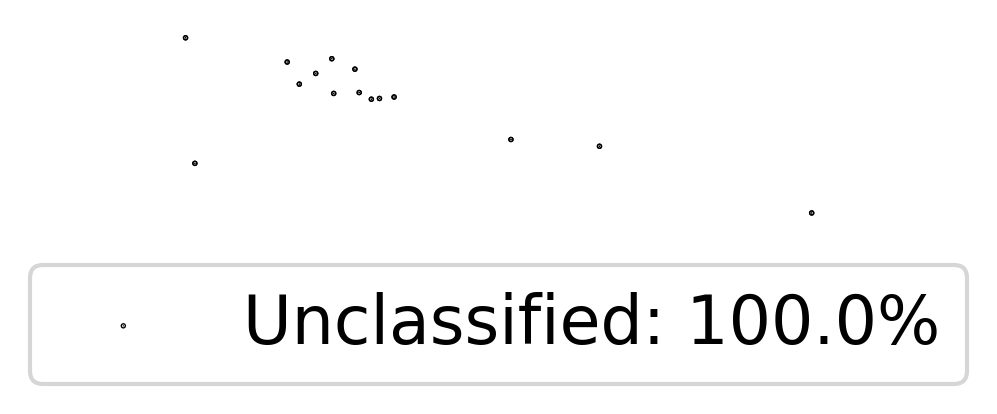

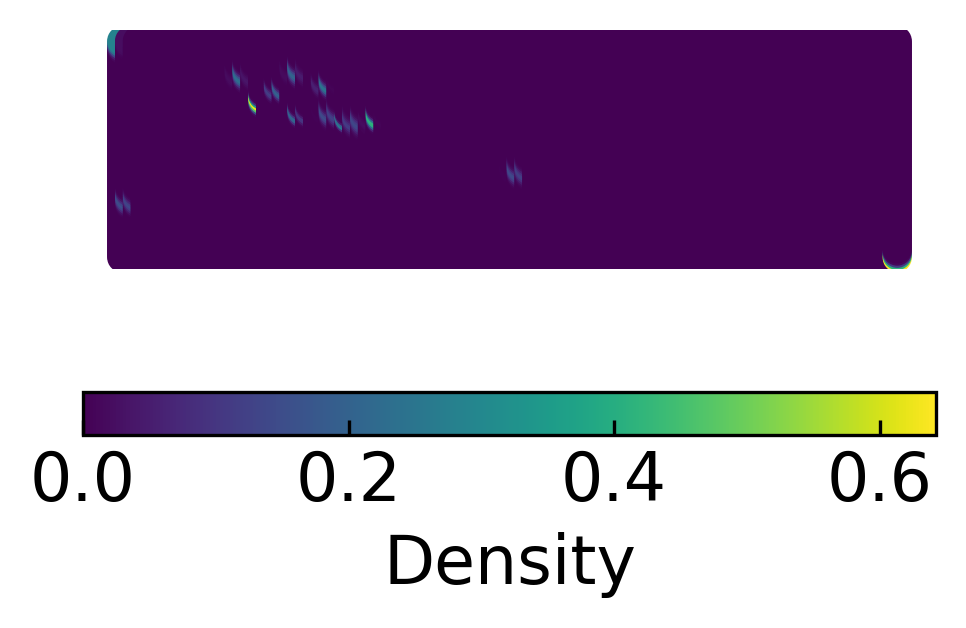

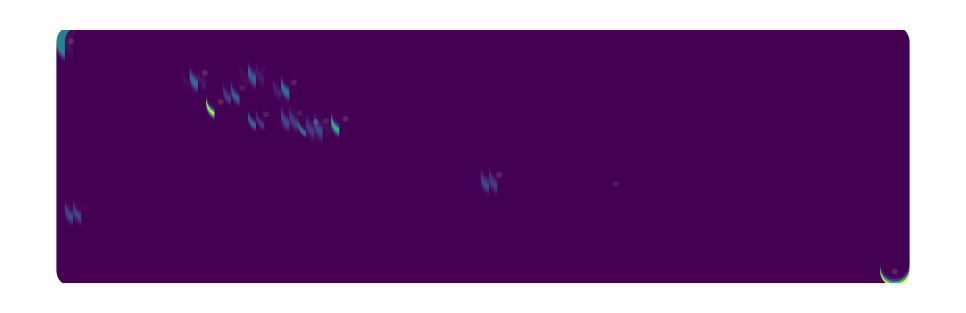

/usr/local/lib/python3.10/dist-packages/mat_discover/mat_discover_.py:1491: UserWarning:

Skipping group cross-validation plot



In [28]:
disc.plot()

In [29]:
from os import path
from mat_discover.utils.pareto import pareto_plot

x = "DensMAP Dim. 1"
y = "DensMAP Dim. 2"

formulas = disc.all_inputs.apply(lambda s: s.composition.reduced_formula)
spg_info = disc.all_inputs.apply(lambda s: s.get_space_group_info())
spg_str = spg_info.apply(lambda s: s[0])
spg_num = spg_info.apply(lambda s: s[1])
num_sites = disc.all_inputs.apply(lambda s: s.num_sites)

targ_df = pd.DataFrame(
    {
        x: disc.std_emb[:, 0],
        y: disc.std_emb[:, 1],
        "target": disc.all_target,
        "spg_num": spg_num,
        "spg_str": spg_str,
        "formula": formulas,
        "num_sites": num_sites,
        disc.input_type: disc.all_inputs,
    }
)

In [32]:
fig = pareto_plot(
    targ_df,
    x=x,
    y=y,
    color="spg_num",
    fpath=path.join(disc.figure_dir, "px-spg-scatter"),
    pareto_front=False,
    parity_type=None,
    color_unit=None,
    use_plotly_offline=disc.use_plotly_offline,
    hover_data=["formula", "spg_num", "spg_str", "num_sites"],
)

In [33]:
fig = pareto_plot(
    targ_df,
    x=x,
    y=y,
    color="num_sites",
    fpath=path.join(disc.figure_dir, "px-num-sites-scatter"),
    pareto_front=False,
    parity_type=None,
    color_unit=None,
    use_plotly_offline=disc.use_plotly_offline,
    hover_data=["formula", "spg_num", "spg_str", "num_sites"],
)

In [34]:
fig = pareto_plot(
    targ_df,
    x=x,
    y=y,
    color="target",
    fpath=path.join(disc.figure_dir, "px-num-sites-scatter"),
    pareto_front=False,
    parity_type=None,
    color_unit=None,
    use_plotly_offline=disc.use_plotly_offline,
    hover_data=["formula", "spg_num", "spg_str", "num_sites"],
)